In [1]:
#https://motius.breezy.hr/p/0b622aa1163e01-join-our-tech-community-as-working-student-m-f-d/apply?utm_source=pt-linkedin&utm_medium=job-posting

In [2]:
from transformers import  AutoModel,AutoTokenizer,AutoModelForMaskedLM , Trainer,TrainingArguments,\
BitsAndBytesConfig,pipeline,default_data_collator,DataCollatorWithPadding,DataCollatorForLanguageModeling
from transformers.utils import move_cache
from chat_template_utils import get_json_schema
from llama_cpp import Llama
from utils import *
from peft import *
import datasets
import torchmetrics
import torch
from torch.utils.data.dataloader import DataLoader,Dataset
from hqq.engine.hf import HQQModelForCausalLM
from hqq.models.hf.base import AutoHQQHFModel
from huggingface_hub import snapshot_download
#import deepspeed
import os
import pandas as pd
import json
from var_dump import var_dump
from bs4 import BeautifulSoup,PageElement,Comment
import matplotlib.pyplot as plt
import seaborn as sns

cache_dir='/var/tmp/.cache/' #'/proj/ciptmp/ix05ogym/.cache/'
output_dir = cache_dir+'outputs/'

move_cache(cache_dir)


No ROCm runtime is found, using ROCM_HOME='/usr'
/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


0it [00:00, ?it/s]

In [3]:
data = pd.read_excel('forms.xlsx',index_col=0)
data

,form
0,"<form class=""flex w-full max-w-xl flex-col gap..."
1,"<form accept-charset=""UTF-8"" action=""https://c..."
2,"<form data-testid=""ApplyStep1Form"" method=""POS..."
3,"<form novalidate="""">\n <div class=""sc-uJiQo eq..."
4,"<form class=""elementor-form"" method=""post"" nam..."
...,...
169,"<form class="""" method=""post"" action=""https://c..."
170,"<form id=""careerform"" name=""careerform"" action..."
171,"<form class=""mod-footer__newsletter-form hidde..."
172,"<form class=""form form--methods clearfix"" id=""..."


In [4]:
def preprocess_form(form):
    if isinstance(form,str):
        form = BeautifulSoup(form,'html.parser')
        
    form:PageElement
    comments=form.find_all(string=lambda text: isinstance(text, Comment))
    for comment in comments:
        comment.extract()
    all_tags = form.find_all()

    # Remove all tags except for 'link', 'input', and 'select' tags
    i=0
    for element in all_tags:
        element:PageElement
        for k in ['style','class','bounding_box_rect','is_clickable']:
            if k in element.attrs:
                    del element[k]
                    pass
           
        if 'type' in element.attrs and element.attrs['type']=='hidden':
            element.unwrap()
            pass
            
        
        #if element.name  in ['div','text']: 
        if element.name not in ['a', 'input', 'select','radio','button','textarea','checkbox','option']:
            
            element.unwrap()
            #print(element)
            pass
        else:
            #element['backend_node_id']=i
            pass

            
                
            i+=1
            
    #print(form.prettify() )
    return form
    
import re

def get_query_element(f):
    query_element=[]
    mytext  = ''
    for element in f:
        # Get the text before the element
        #print('-----------------------------')
        if element.name == None:
            t = element.text.replace('\n','').replace('\t','').strip()
            if t!='':
                mytext+=t+'\n '
        else:
            query_element.append({'query':mytext,'element': str(element).replace('\n','').replace('  ','').strip()})
            mytext =''
        
    return query_element


def get_query_html(f):
    f:PageElement
    childs = f.find_all(string=True,recursive=False)
    for c in childs:
        print('---------------------')
        print(c)
    pass
    
    
    
f = preprocess_form(data['form'][11])

d = get_query_element(f)
print(d)

[{'query': '', 'element': '<input aria-label="Search by keyword" maxlength="50" name="q" placeholder="Search by keyword" type="text"/>'}, {'query': '', 'element': '<input aria-label="Search by location" maxlength="50" name="locationsearch" placeholder="Search by location" type="text"/>'}, {'query': '', 'element': '<input type="submit" value="Search jobs"/>'}, {'query': '', 'element': '<a aria-controls="moreOptionsDiv" aria-expanded="false" data-lessoptions="Show Fewer Options" data-moreoptions="Show more options" data-target=".optionsDiv" data-toggle="collapse" href="javascript:void(0)" id="options-search" rel="advance" role="button"> Show more options</a>'}, {'query': 'Loading...\n Work area\n ', 'element': '<select id="optionsFacetsDD_department" name="optionsFacetsDD_department"><option value="">All </option></select>'}, {'query': 'Career status\n ', 'element': '<select id="optionsFacetsDD_customfield3" name="optionsFacetsDD_customfield3"><option value="">All </option></select>'}, {

In [5]:
dd = pd.read_pickle('input_text.pkl')
dd_forms = dd.drop_duplicates(['text']).reset_index(drop=True)#['text']


x = preprocess_form(dd_forms.loc[67,'text'])
get_query_element(x)


[{'query': 'cv or resume*upload your cv or resume file\n ',
  'element': '<input accept="application/msword, application/vnd.openxmlformats-officedocument.wordprocessingml.document, application/pdf, application/vnd.oasis.opendocument.text, application/rtf, text/plain, image/png, image/jpeg" aria-describedby="input-candidate.cv-3-error input-candidate.cv-4" aria-hidden="true" aria-invalid="false" aria-labelledby="input-candidate.cv-5" autocomplete="off" data-cy="fileinputfield" id="input-candidate.cv-3" name="candidate.cv" required="" tabindex="-1" type="file"/>'},
 {'query': 'upload a fileaccepted files: pdf, doc, docx, jpeg and png up to 50mb.my informationfill out the information belowfull name*\n ',
  'element': '<input aria-describedby="input-candidate.name-6-error" aria-invalid="false" autocomplete="name" id="input-candidate.name-6" maxlength="255" name="candidate.name" placeholder="full name" required="" type="text"/>'},
 {'query': 'email address*\n ',
  'element': '<input aria-d

In [113]:
def get_df_list(data):
    df_list = []
    for i in range(len(data)):
        f = data[i]#,'form']
        f = preprocess_form(f)
        df_list.extend(get_query_element(f))
        #break
    return pd.DataFrame(df_list)
    
    
df_forms_1 = get_df_list(data['form'])
df_forms_2 = get_df_list(dd_forms['text'])

df_forms_1=df_forms_1.drop_duplicates(['query']).drop_duplicates(['element']).reset_index(drop=True)
df_forms_2 = df_forms_2.drop_duplicates(['query']).drop_duplicates(['element']).reset_index(drop=True)

In [7]:
dd_forms[['input_text','labels']]

,input_text,labels
0,personal informationcv or resumebrowse cv to a...,cv
1,"<input data-testid=""textinput"" id=""email"" requ...",email
2,"hr profile*<input class=""fake-cv-button__input...",fake
3,"input autocomplete=""off"" placeholder=""job titl...",other
4,"-mail-address<input class=""apply-application-p...",email
...,...,...
119,"on:<input class=""at-commutetime-frominput job-...",address
120,"og in<button type=""submit"" class=""careersite-b...",login
121,contact infoe-mail addresse-mail addressrequir...,phonenumber
122,"business analyst (m/f/d)*<input type=""file"" si...",cv


In [8]:
embeding_model = 

SyntaxError: invalid syntax (1110871626.py, line 1)

In [ ]:
for i in range(10):
    print(dd_forms_2['element'][i])
    print(dd_forms['element'][i])
    print('------------------------------------------')

<input accept="application/pdf,.pdf" name="cv" tabindex="-1" type="file"/>
<input name="cv" accept="application/pdf,.pdf" type="file" tabindex="-1" style="display: none;">
------------------------------------------
<input autocomplete="email" data-testid="textinput" id="email" name="email" required="" type="email" value=""/>
<input data-testid="textinput" id="email" required="" type="email" autocomplete="email" name="email" class="sc-bsgiji jskkmm" value="">
------------------------------------------
<input data-testid="firstname" id="firstname" name="firstname" required="" type="text" value=""/>
<input class="fake-cv-button__input js-cv-upload-hidden-input" type="file" name="cvborder:cvborder_body:cv:upload:onerowpanel:cvparser:form:cvfileinput" id="idc">
------------------------------------------
<input data-testid="lastname" id="lastname" name="lastname" required="" type="text" value=""/>
<input autocomplete="off" placeholder="jobtitel, stichwort oder unternehmen" type="text" aria-a

             query       element
count  1267.000000   1267.000000
mean     42.564325    205.612470
std     186.832662    738.585334
min       0.000000     16.000000
25%       0.000000     71.000000
50%      13.000000    107.000000
75%      40.000000    188.500000
max    5133.000000  13573.000000


array([[<Axes: title={'center': 'query'}>,
        <Axes: title={'center': 'element'}>]], dtype=object)

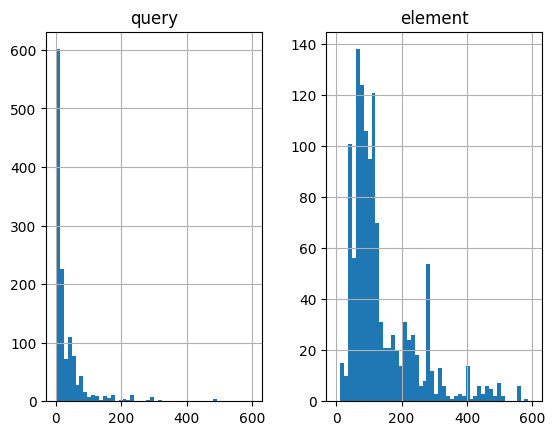

In [ ]:
df = pd.DataFrame(df_list)
nn = df.map(lambda x:len(x))#hist(bins= 50,range=(0,200))
print(nn.describe())
nn.hist(bins= 50,range=(0,600))

In [ ]:
df.loc[nn['element']>700,'element'].reset_index(drop=True)

0     <select aria-describedby="help-block_country_8...
1     <select aria-describedby="help-block" aria-lab...
2     <select id="aside-menu-locations"><option data...
3     <select data-slnm="applicationform-inputselect...
4     <button aria-label='Formular "Benachrichtigung...
5     <select id="ctl00_ctl00_moteurRapideOffre_ctl0...
6     <select id="ctl00_ctl00_moteurRapideOffre_ctl0...
7     <select id="193761" name="193761" tabindex="0"...
8     <select id="9907" name="9907" tabindex="0"><op...
9     <button aria-label="Submit get notified for si...
10    <select aria-invalid="false" data-keyword-list...
11    <select aria-invalid="false" data-keyword-list...
12    <select aria-invalid="false" data-custom-facet...
13    <select aria-invalid="false" data-val="true" d...
14    <button id="button-96629df2" onclick="window.h...
15    <button id="id-9c089dde" onclick="window.heyfl...
16    <select name="section__question_6" ng-model="q...
17    <select name="section__question_7" ng-mode

In [ ]:
$$$$

SyntaxError: invalid syntax (733439656.py, line 1)

In [ ]:
from transformers import Qwen2ForCausalLM
device = 'cuda'
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2-0.5B-Instruct',cache_dir=cache_dir)
model = Qwen2ForCausalLM.from_pretrained('Qwen/Qwen2-0.5B-Instruct'
                                         #,attn_implementation="flash_attention_2"
                                         #,torch_dtype=torch.float16
                                         , device_map='auto',cache_dir=cache_dir)#.to('cuda')

model.eval()
#model.config['use_sliding_window']=True
print(model.config)

model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Qwen2Config {
  "_name_or_path": "Qwen/Qwen2-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Linear(in_featur

In [ ]:
model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.1,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

In [44]:
person = {"first name":"majid","last name":"sharghi foroushani","pronoun":"he","birth":"10/08/1997","age":"27","sex":"male","skill":"NLP,LLM","country":"Germany","address":"Philip-9","city":"Erlangen","phone":"+497773154","available_from":"6/24/2024","salary":"10000","German_language_level":"A1","English_language_level":"C1","visa":"do not need visa","email":"sharghi.majid@gmail.com","password":"123456","find us":"Google","xing":"www.xing.com","job":"I am stduent","university":"FAU","major":"AI"}
person['zip']="91052"
person['custom question']=""

In [ ]:
#user_content = """what is your gender?"""
#user_content = """where are you living?(optional)"""
#user_content = "what is your salary expectation?*"
#user_content = "Which pronouns should we use to address you? (optional)"
#user_content = "how is your German?"
#user_content = "do you need visa spunsership?"
#user_content = "where are you working right now?"
#user_content = "what is your birth day?"
#user_content = "what are your hobbies?"
#user_content = "password"
#user_content = "what projects have you done?"
#user_content = "are you a text ai?"
#user_content = "what experice do you have in network engineering?"
#user_content = "what projects have you done in deep learning?"
#user_content = "how did you find us?"
#user_content = "use html to create email"


#user_content = """type your password\n"""
person = {"first name":"majid","last name":"sharghi foroushani","pronoun":"he","birth":"10/08/1997","age":"27","sex":"male","skill":"NLP,LLM","country":"Germany","address":"Philip-9","city":"Erlangen","phone":"+497773154","available_from":"6/24/2024","salary":"10000","German_language_level":"A1","English_language_level":"C1","visa":"do not need visa","email":"sharghi.majid@gmail.com","password":"123456","find us":"Google","xing":"www.xing.com","job":"I am stduent","university":"FAU","major":"AI"}
system_content = str(person)+""".\nYour answer has to be in short json format like {"answer":""}."""
#system_content="""You are majid sharghi foroushani. you are 27 years old and your skills are mainly NLP and software development. you are living in Erlangen which is a city in germany. Your German is A1 and my English is C1. your phone number is +497773154 and your salary expectation is 10000 per year and you are available to work from 6/24/2024."""
input = tokenizer.apply_chat_template([{"role":"system","content":"""User gives you a json use the information to answer. Answer is in json format with exactly one field. your answer should be related to user experience."""}
                                       ,{"role":"user","content":system_content}
                                       ,{"role":"assist","content":"""{"answer":"?"}"""}
                                       ,{'role':"user","content":user_content}],add_generation_prompt=False,return_tensors='pt').to(device)
#input = tokenizer(user_content,return_tensors='pt').to('cuda')['input_ids']
print(input.shape)
with torch.no_grad():
    out = model.generate( input,max_length=512,num_beams=1,do_sample=False)
    
print(out.shape)
print(tokenizer.decode(token_ids=out[0]))

torch.Size([1, 247])
torch.Size([1, 354])
<|im_start|>system
User gives you a json use the information to answer. Answer is in json format with exactly one field. your answer should be related to user experience.<|im_end|>
<|im_start|>user
{"first name":"majid","last name":"sharghi foroushani","pronoun":"he","birth":"10/08/1997","age":27,"sex":"male","skill":"NLP,LLM","country":"Germany","address":"Philip-9","city":"Erlangen","phone":"+497773154","available_from":"6/24/2024","salary":"10000","German_language_level":"A1","English_language_level":"C1","visa":"do not need visa","email":"sharghi.majid@gmail.com","password":"123456","find us":"Google","xing":"www.xing.com","job":"I am stduent","university":"FAU","major":"AI"}.
Your answer has to be in short json format like {"answer":""}.<|im_end|>
<|im_start|>assist
{"answer":"?"}<|im_end|>
<|im_start|>user
use html to create email<|im_end|>
<|im_start|>assist
{"answer":"<html><head><title>Dear Majid Sharghi Foroushani</title></head><body>

In [ ]:
tokenizer.eos_token

'<|im_end|>'

In [9]:
from sentence_transformers  import SentenceTransformer

embeding_model= AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L12-v2',cache_dir=cache_dir)
embdeding_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L12-v2',cache_dir=cache_dir)
embeding_model.eval()
embeding_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
train_data = datasets.Dataset.from_pandas(df_forms_1)
train_data[0]

{'query': 'Personal information\n CV or resume\n Browse CV to autocomplete your application. You can still fill your profile manually.\n ',
 'element': '<input accept="application/pdf,.pdf" name="cv" tabindex="-1" type="file"/>'}

In [10]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [55]:
KEYWORDS.pop('eligible')
KEYWORDS.pop('apply')



['apply']

In [57]:
def batch_tok(example):

    return embdeding_tokenizer(example,padding=True,truncation=True,max_length=512,return_tensors='pt')



LABEL_INDEX_TO_KEY = list(KEYWORDS.keys())

query_token = embdeding_tokenizer(df_forms_1['query'].tolist(),padding=False,truncation=True,max_length=512)
element_token = embdeding_tokenizer(df_forms_1['element'].tolist(),padding=False,truncation=True,max_length=512)
classes_token = embdeding_tokenizer(LABEL_INDEX_TO_KEY,padding=True,truncation=True,max_length=512,return_tensors='pt')


def myheatmap(x):
    map =[]
    for i in range(len(x)):
        sim = torch.cosine_similarity(x,x[i])
        map.append(sim)
    
    
    plt.figure(figsize=(10,10))
    sns.heatmap(map)
    plt.show()
    
    

with torch.no_grad():
    
    output = embeding_model(**classes_token)
    #class_embdeding = torch.mean(output.last_hidden_state,1)
    class_embdeding = mean_pooling(output,classes_token['attention_mask'])
    class_embdeding = torch.nn.functional.normalize(class_embdeding, p=2, dim=1)
    #sim = torch.cosine_similarity(class_embdeding,class_embdeding[0])
    
    #print(sim.shape)
    pass
    
i = 151
with torch.no_grad():
    x = torch.tensor(element_token['input_ids'][i:i+1])
    #print(x)
    output = embeding_model(input_ids= x)
    #query_embdeding = torch.mean(output.last_hidden_state,1)
    query_embdeding = mean_pooling(output,torch.tensor(element_token['attention_mask'][i:i+1]))
    #query_embdeding = torch.nn.functional.normalize(class_embdeding, p=2, dim=1)
    
    sim = torch.cosine_similarity(class_embdeding,query_embdeding)
    print(pd.DataFrame({'value':sim,'label':LABEL_INDEX_TO_KEY}).sort_values('value',ascending=False)[:5])
    print(LABEL_INDEX_TO_KEY[ sim.argmax() ], embdeding_tokenizer.decode(token_ids=x[0]))
    print(df_forms_1['element'][i] )
    

#myheatmap(class_embdeding)


       value           label
50  0.353188         country
52  0.195331  available from
49  0.178588          search
25  0.148569          submit
34  0.126076         dropbox
country [CLS] < select aria - describedby = " help - block _ country _ 8 apply - description - country _ 8 " aria - labelledby = " label _ country _ 8 " aria - required = " false " id = " country _ 8 " name = " country " > < option value = " " > - - please select - - < / option > < option value = " country _ afghanistan " > afghanistan < / option > < option value = " country _ albania " > albania < / option > < option value = " country _ algeria " > algeria < / option > < option value = " country _ andorra " > andorra < / option > < option value = " country _ angola " > angola < / option > < option value = " country _ antigua " > antigua < / option > < option value = " country _ argentina " > argentina < / option > < option value = " country _ armenia " > armenia < / option > < option value = " country _ aruba " > 

In [58]:
KEYWORDS={
        #----------------------form--------------------------------------
       'first name':['firstname','first_name','forename','first','first-name'],
       'last name':['lastname','last_name','surename','last','last-name'] ,
       'email':['email','e-mail','username','user_name','user-name','type="email"'], 
       'password':['password'], 
       'cv':['cv','resume','curriculum','vitae'],
       'birth date':['birthdate','birth','dateofbirth','date-of-birth','birth-date'],
       'phone number':['phonenumber','phone','telephone','tel'],
       'house number':['hausnummer'],
       'resident country':['resident','country'],
       'citizen country':['citizen','citizenship','city'],
       'transcript':['transcript'],
       'cover letter':['coverletter','cover', 'letter'], 
       'picture':['picture'], 
       'address':['address','location'],
       'linkedin':['linkedin'],
       'github':['github'],
       'xing':['xing'],
       'twitter':['twitter'],
       'website':['website'],
       'zip':['postalcode','zip','zip-code','postal'],
       'city':['city'],
       'salary':['salary'],
       'sex':['sex','gender'], 
       'available from':['noticeprieod'],
       #'file':['type="file"'],
       
       'captcha':['captcha'],
       'submit':['apply','type="submit"'],
       'cancel':['cancel'],
       'fake':['fake'],
       'custom question':['question'],
       'privacy':['agree'],

       'recommend':['recommendation'],
       'work here before':['workherebefore'],
       'find us':['find'],
       'dropbox':['dropbox'],
       'google drive':['google drive'],
       'work hours':['workhours'],
       'workduration':[''],
       'visa':['visa'],
       #'eligible':['eligible'],
       'german language level':['germanlevel'],
       'company':[''],#current company
       'willing to relocate':[''],
       'university enrollment':[],#are a student?
       'english language level':[],
       #important about job
       #important about jobplace?
              
       #-------------------------------------------------------------------
       #-----------------------------------btns ---------------------------
       'login':['login','sign'],
       'username':['username'],
       'register':['register','sign'],
       'cookie':['cookie'],
       'next':['apply now','next'],
       'search':[],
        'other':['other'],
        'newsletter':[]
       #'apply':['apply'],
       #-------------------------------------------------------------------

       }

LABEL_INDEX_TO_KEY = [KEYWORDS.keys()]

In [195]:
k = 'name="available_from"'
d = 'available from'
c1 = df_forms_1['query'].str.contains(k, case=False, na=False)
c2 = df_forms_1['element'].str.contains(k, case=False, na=False)
c = df_forms_1[c2]#.reset_index(drop=True)

for i,x in c.iterrows():
    print(x['query'])
    print(x['element'])
    #if  pd.isna(df_forms_1.loc[i,'label']):
    df_forms_1.loc[i,'label']= d#pd.NA
    print(i)
    print('-------------------------------------------------------------')
    
c

Available from *
 
<input name="available_from" placeholder="" required="" type="text"/>
5
-------------------------------------------------------------


,query,element,label
5,Available from *\n,"<input name=""available_from"" placeholder="""" re...",NaN


In [197]:


df_forms_1[df_forms_1['label'].notna()]



,query,element,label
0,Personal information\n CV or resume\n Browse C...,"<input accept=""application/pdf,.pdf"" name=""cv""...",cv
1,Name *\n,"<input name=""first_name"" placeholder=""First"" r...",first name
2,This field contains invalid characters\n,"<input name=""last_name"" placeholder=""Last"" req...",last name
3,This field contains invalid characters\n Email...,"<input name=""email"" placeholder=""yourmail@doma...",email
4,Phone\n,"<input name=""phone"" placeholder=""+49 176 123 4...",phone
...,...,...,...
419,cover letter\n upload your cover letter\n,"<input accept=""application/msword, application...",cover letter
434,github\n,"<input name=""custom_attribute_356304"" placehol...",guthub
436,ihre e-mail-adresse\n,"<button aria-label=""subscribe for newsletter"" ...",submit
438,(!)\n this field is required\n,"<button id=""uploaddropboxresume"" type=""submit""...",submit


In [182]:
dd_forms

,text,element,label,input_text,labels
0,personal informationcv or resumebrowse cv to a...,"<input name=""cv"" accept=""application/pdf,.pdf""...",cv,personal informationcv or resumebrowse cv to a...,cv
1,"*<input data-testid=""textinput"" id=""email"" req...","<input data-testid=""textinput"" id=""email"" requ...",email,"<input data-testid=""textinput"" id=""email"" requ...",email
2,"ihr profil*<input class=""fake-cv-button__input...","<input class=""fake-cv-button__input js-cv-uplo...",cv,"hr profile*<input class=""fake-cv-button__input...",fake
3,"<input autocomplete=""off"" placeholder=""jobtite...","<input autocomplete=""off"" placeholder=""jobtite...",phonenumber,"input autocomplete=""off"" placeholder=""job titl...",other
4,"e-mail-adresse<input class=""apply-application-...","<input class=""apply-application-process-render...",email,"-mail-address<input class=""apply-application-p...",email
...,...,...,...,...,...
119,"von:<input class=""at-commutetime-frominput job...","<input class=""at-commutetime-frominput job-ad-...",firstname,"on:<input class=""at-commutetime-frominput job-...",address
120,"log in<button type=""submit"" class=""careersite-...","<button type=""submit"" class=""careersite-button...",apply,"og in<button type=""submit"" class=""careersite-b...",login
121,kontaktinfoe-mail-adressee-mail-adresserequire...,"<input class="" artdeco-text-input--input"" id=""...",phonenumber,contact infoe-mail addresse-mail addressrequir...,phonenumber
122,"business analyst (m/w/d)*<input type=""file"" si...","<input type=""file"" size=""20"" aria-labelledby=""...",cv,"business analyst (m/f/d)*<input type=""file"" si...",cv


In [198]:
df_forms_1.loc[436,'label']='newsletter'#'submit'

In [199]:
df_forms_1.to_excel('forms.xlsx',index=0)